In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import open, example_pid, my_pid, pid
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()


/Users/freeklinssen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_rollout(sim):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
  ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
  ax.plot([x.roll_lataccel for x in sim.state_history], label="Roll Lateral Accelration", alpha=0.5)
  ax.plot([x.a_ego for x in sim.state_history], label="foreward accelration", alpha=0.5)
  ax.plot(sim.action_history, label="Steer History", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()
  
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot([x.v_ego for x in sim.state_history], label="speed", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Speed")
  ax.set_title("Rollout")
  plt.show()
  
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot([sim.current_lataccel_history[i]- sim.target_lataccel_history[i] for i in range(len(sim.target_lataccel_history))], label="difference", alpha=0.5)
  ax.plot([x.roll_lataccel for x in sim.state_history], label="foreward accelration", alpha=0.5)
  #ax.plot([sim.roll_lataccel[i-1]- sim.roll_lataccel[i] for i in range(1, len(sim.roll_lataccel))], label="foreward accelration", alpha=0.5)
  
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Speed")
  ax.set_title("Rollout")
  plt.show()
  
  

In [3]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)

In [4]:
from scipy.stats import pearsonr
controller = my_pid.Controller()
sim = TinyPhysicsSimulator(model, "./data/00000.csv", controller=controller, debug=False)
sim.rollout()

#{'lataccel_cost': lat_accel_cost, 'jerk_cost': jerk_cost, 'total_cost': total_cost}
losses  = sim.compute_cost()
print(losses['lataccel_cost'])
print(losses['jerk_cost'])
print(losses['total_cost'])

history = sim.return_history()
lataccel_history = np.diff(np.array(history['lataccel_history'][99:]))
action_history = np.array(history['action_history'][100:])
print(history['state_history'])
roll_lataccel_history = np.array([x[0] for x in history['state_history']][100:])
vEgo_history = np.array([x[1] for x in history['state_history']][100:])
aEgo_history = np.array([x[2] for x in history['state_history']][100:])



# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr([sim.current_lataccel_history[i]- sim.target_lataccel_history[i] for i in range(len(sim.target_lataccel_history))],
                                [x.roll_lataccel for x in sim.state_history])

print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")

1.2778179967628955
44.16764098197033
108.0585408201151
[State(roll_lataccel=0.36749025401205637, v_ego=33.770259857177734, a_ego=-0.0172996744513511), State(roll_lataccel=0.36294632006596805, v_ego=33.76353329688475, a_ego=-0.0390689050973944), State(roll_lataccel=0.3584023081421195, v_ego=33.7559494075436, a_ego=-0.067940061457964), State(roll_lataccel=0.3587627564967035, v_ego=33.75833365816382, a_ego=-0.022276434514991), State(roll_lataccel=0.3594747526408039, v_ego=33.752903797375545, a_ego=-0.0520323872778797), State(roll_lataccel=0.3603430801999454, v_ego=33.75393897160159, a_ego=-0.0130699642230813), State(roll_lataccel=0.36139567754279095, v_ego=33.748666944516614, a_ego=-0.0429204111596332), State(roll_lataccel=0.3624482707192681, v_ego=33.74425976370754, a_ego=-0.0429179585332166), State(roll_lataccel=0.3601454408869036, v_ego=33.74331042579862, a_ego=-0.0089320793364471), State(roll_lataccel=0.3575815177921467, v_ego=33.7441404364284, a_ego=0.0003421859984075), State(roll_la

'\n# Initialize layout\nfig, ax = plt.subplots(figsize=(6, 6))\n\n# Add scatterplot\nax.scatter(action_history, lataccel_history, s=60, alpha=0.7, edgecolors="k")\n\n# Fit linear regression via least squares with numpy.polyfit\n# It returns an slope (b) and intercept (a)\n# deg=1 means linear fit (i.e. polynomial of degree 1)\nb, a = np.polyfit(action_history, lataccel_history, deg=1)\nprint(a)\nprint(b)\n# Create sequence of 100 numbers from 0 to 100\nxseq = np.linspace(-0.5, 0.5, num=100)\n\n# Plot regression line\nax.plot(xseq, a + b * xseq, color="k", lw=2.5)\n'

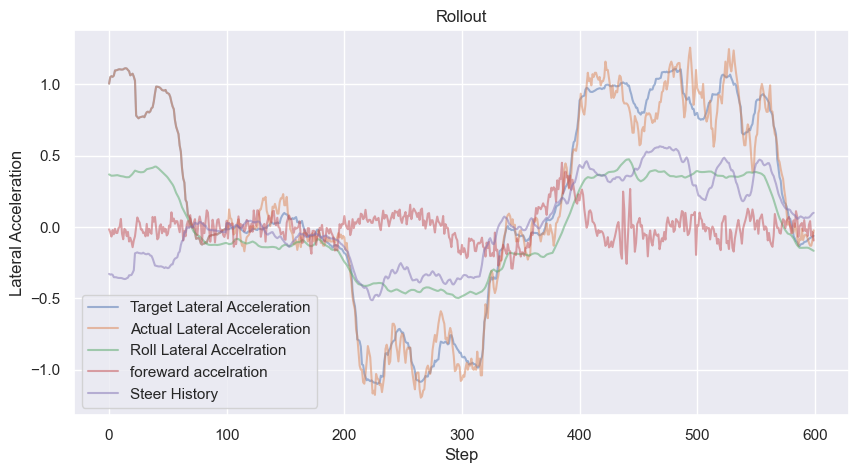

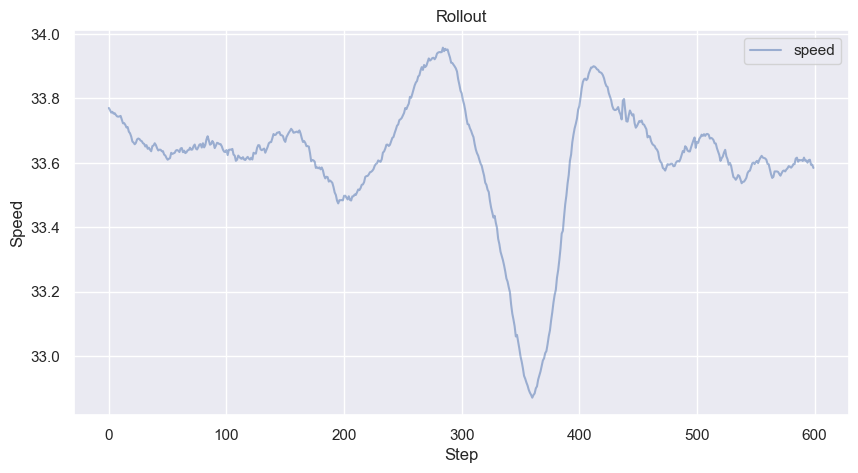

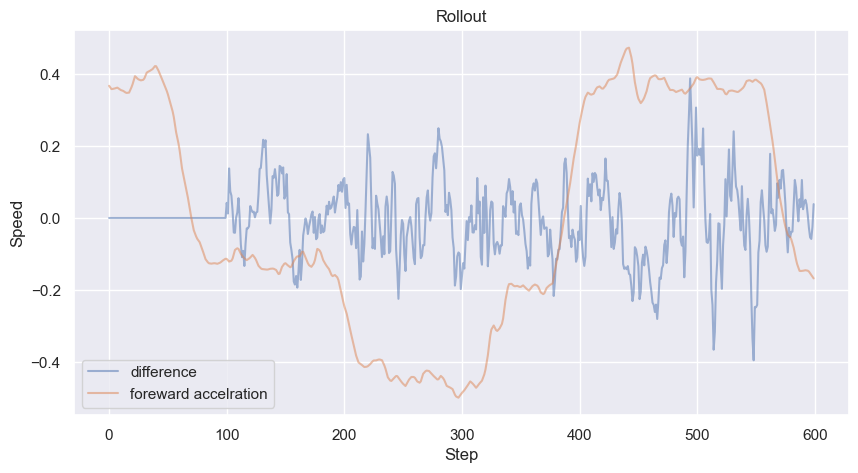

In [5]:
plot_rollout(sim)

In [6]:
count = 200
lataccel_cost = 0
jerk_cost = 0
total_cost = 0 

for i in range(count):
    print(i)
    controller = my_pid.Controller()
    num = str(i).zfill(5)
    sim = TinyPhysicsSimulator(model, "./data/%s.csv"%num, controller=controller, debug=False)
    sim.rollout()

    
    losses  = sim.compute_cost()
    lataccel_cost += losses['lataccel_cost']
    jerk_cost += losses['jerk_cost']
    total_cost += losses['total_cost']


lataccel_cost = lataccel_cost/count
jerk_cost = jerk_cost/count
total_cost = total_cost/count

print(lataccel_cost)
print(jerk_cost)
print(total_cost)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.8273897918938136
34.74940522989377
76.11889482458446


In [8]:
# my pid
0.725722067745967
27.643252541572405
63.9293559288708

# simple pid
1.8588552422593756
31.148734791926955
124.0914969048956

124.0914969048956